In [7]:
import numpy as np

def generate_random_ising(size, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    return np.random.choice([-1, 1], size=(size, size))


def calculate_hamiltonian(lattice, J=1, B=0):
    size = lattice.shape[0]
    energy = 0
    
    for i in range(size):
        for j in range(size):
            S = lattice[i, j]
            neighbors = [
                lattice[(i+1) % size, j],          #periodic boundary conditions
                lattice[i, (j+1) % size]
            ]
            energy += -J * S * sum(neighbors)
    
    energy -= B * np.sum(lattice)
    
    return energy

# Example usage
size = 3
seed = 42
lattice = generate_random_ising(size, seed)

Ham = calculate_hamiltonian(lattice)

print(lattice)
print(Ham)

[[-1  1 -1]
 [-1 -1  1]
 [-1 -1 -1]]
-2


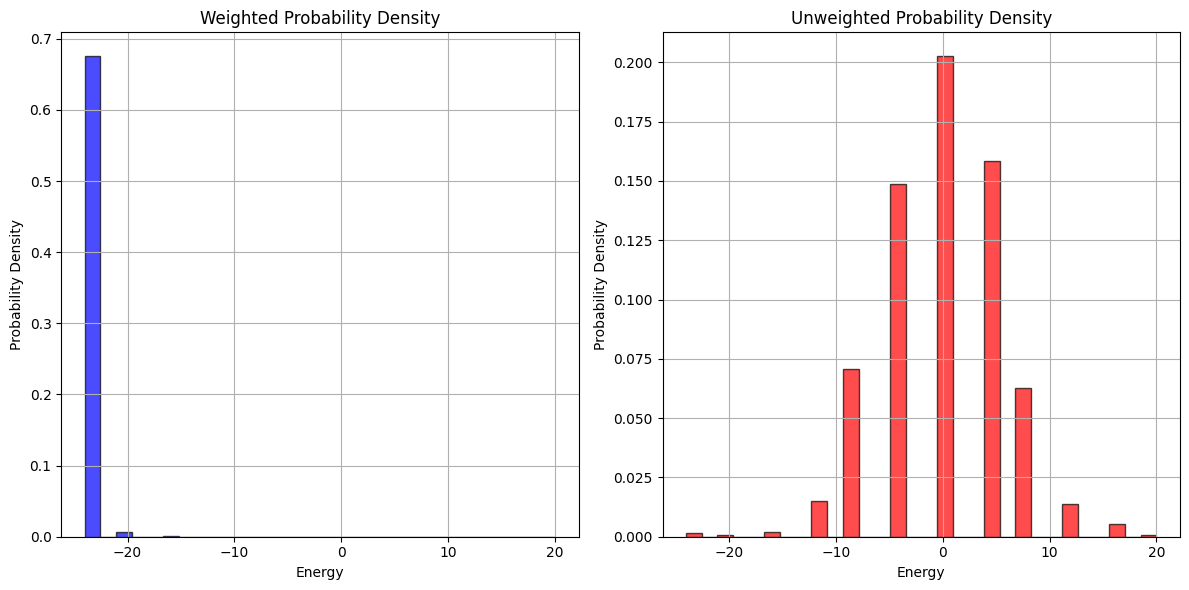

In [12]:
import matplotlib.pyplot as plt

def sample_probability_density(size, J=1, B=0, T=1, iterations=1000, seed=None):
    """
    Sample the probability density function of the Ising model.
    
    Parameters:
        size (int): Side length of the lattice.
        J (float): Interaction strength between neighboring spins.
        B (float): External magnetic field strength.
        T (float): Temperature.
        iterations (int): Number of samples to generate.
        seed (int, optional): Random seed for reproducibility.
    
    Returns:
        tuple: (energies, weights), arrays of energy values and their Boltzmann weights.
    """
    if seed is not None:
        np.random.seed(seed)
    
    energies = []
    weights = []
    
    for _ in range(iterations):
        lattice = generate_random_ising(size)
        E = calculate_hamiltonian(lattice, J, B)
        weight = np.exp(-E / T)
        
        energies.append(E)
        weights.append(weight)
    
    return np.array(energies), np.array(weights)

def plot_probability_density(energies, weights):
    """
    Plot the probability density function as a function of energy.
    
    Parameters:
        energies (np.ndarray): Array of energy values.
        weights (np.ndarray): Corresponding Boltzmann weights.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    axs[0].hist(energies, weights=weights, bins=30, density=True, alpha=0.7, color='b', edgecolor='black')
    axs[0].set_xlabel('Energy')
    axs[0].set_ylabel('Probability Density')
    axs[0].set_title('Weighted Probability Density')
    axs[0].grid()
    
    axs[1].hist(energies, bins=30, density=True, alpha=0.7, color='r', edgecolor='black')
    axs[1].set_xlabel('Energy')
    axs[1].set_ylabel('Probability Density')
    axs[1].set_title('Unweighted Probability Density')
    axs[1].grid()
    
    plt.tight_layout()
    plt.show()

# Example usage
size = 4
seed = 42
J = 1
B = 0
T = 1
iterations = 1000

energies, weights = sample_probability_density(size, J, B, T, iterations, seed)
plot_probability_density(energies, weights)



Above I've plotted a sample of the possible energies. I've plotted both the histogram weighted by Boltzmann factors and one without to highlight that the lowest energy states only dominate the system because of the low temperature. The unweighted distribution looks like a normal distribution.



Now I'll try Gibb's sampling. I'll select a spin state at random, and then calculate the conditional probability of what the spin state is GIVEN the existing spins in it's neighborhood.

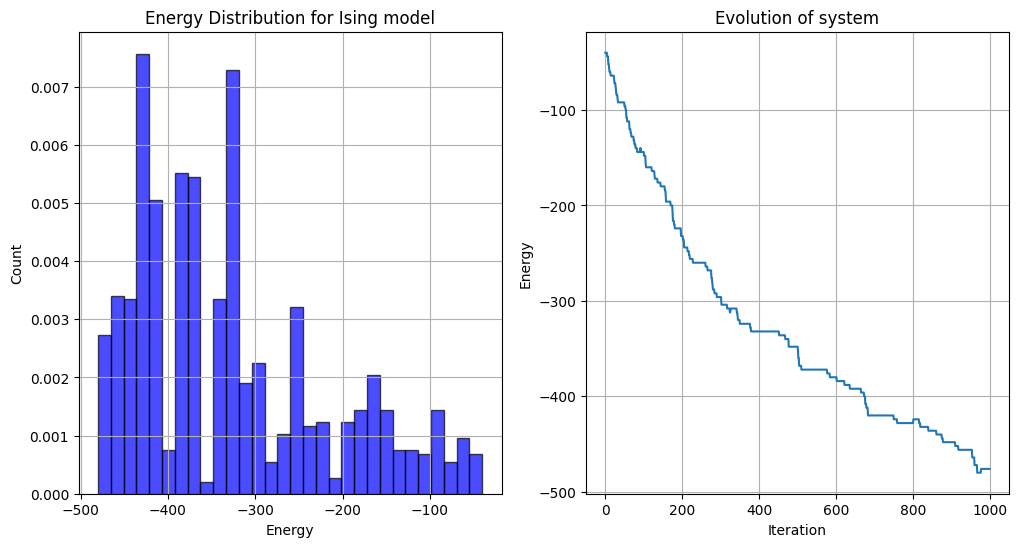

In [ ]:
def gibbs_sampling(lattice, J=1, B=0, T=1, n_iterations=1000):
    """
    Perform Gibbs sampling on the Ising model.
    
    Parameters:
        lattice (np.ndarray): Initial lattice configuration.
        J (float): Interaction strength between neighboring spins.
        B (float): External magnetic field strength.
        T (float): Temperature.
        n_iterations (int): Number of Gibbs sampling iterations.
    
    Returns:
        np.ndarray: Updated lattice configuration after Gibbs sampling.
    """
    size = lattice.shape[0]

    E_history = []        #stores the energies of the lattices we've sampled
    
    for _ in range(n_iterations):
        i, j = np.random.randint(0, size, size=2)  # Select a random spin
        S = lattice[i, j]
        
        neighbors = lattice[(i+1) % size, j] + lattice[(i-1) % size, j] + \
                    lattice[i, (j+1) % size] + lattice[i, (j-1) % size]
        
        delta_E = 2 * J * S * neighbors + 2 * B * S
        
        p = 1 / (1 + np.exp(delta_E / T))  # Gibbs probability
        
        if np.random.rand() < p:
            lattice[i, j] *= -1  # Flip spin with probability p

        E_history.append(calculate_hamiltonian(lattice))
    
    return E_history


Energy_hist = gibbs_sampling(generate_random_ising(size = 20))         #will sample 1000 states

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
axs[0].hist(Energy_hist, bins=30, density=True, alpha=0.7, color='b', edgecolor='black')
axs[0].set_xlabel('Energy')
axs[0].set_ylabel('Count')
axs[0].set_title('Energy Distribution for Ising model')
axs[0].grid()

axs[1].plot(Energy_hist)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Energy')
axs[1].set_title('Evolution of system')
axs[1].grid()




Based off my above plots, I didn't give the system enough time to converge. I'll do this again. 

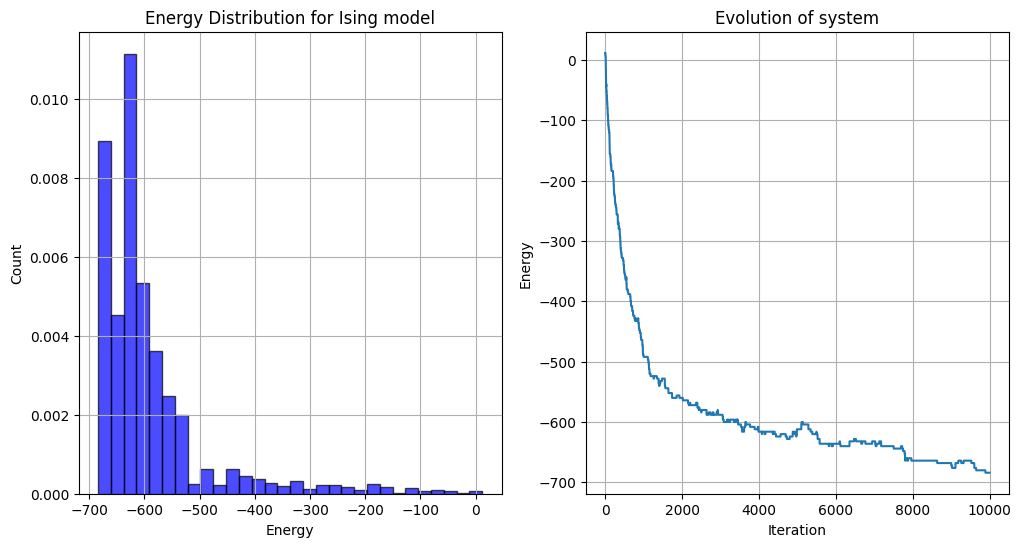

In [15]:
Energy_hist = gibbs_sampling(generate_random_ising(size = 20), n_iterations=10000)         

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
axs[0].hist(Energy_hist, bins=30, density=True, alpha=0.7, color='b', edgecolor='black')
axs[0].set_xlabel('Energy')
axs[0].set_ylabel('Count')
axs[0].set_title('Energy Distribution for Ising model')
axs[0].grid()

axs[1].plot(Energy_hist)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Energy')
axs[1].set_title('Evolution of system')
axs[1].grid()

This looks a bit better. But maybe I should try initially starting with a state where everything has the same spin. That way we don't have to do so many iterations to get to a low energy state.

I tried this below, and it appears that for T=1, the uniform state is the most favored. I'll try a different temperature just so we don't get something so boring. For T=10 it looks like 2000 iterations is a good burn in period.

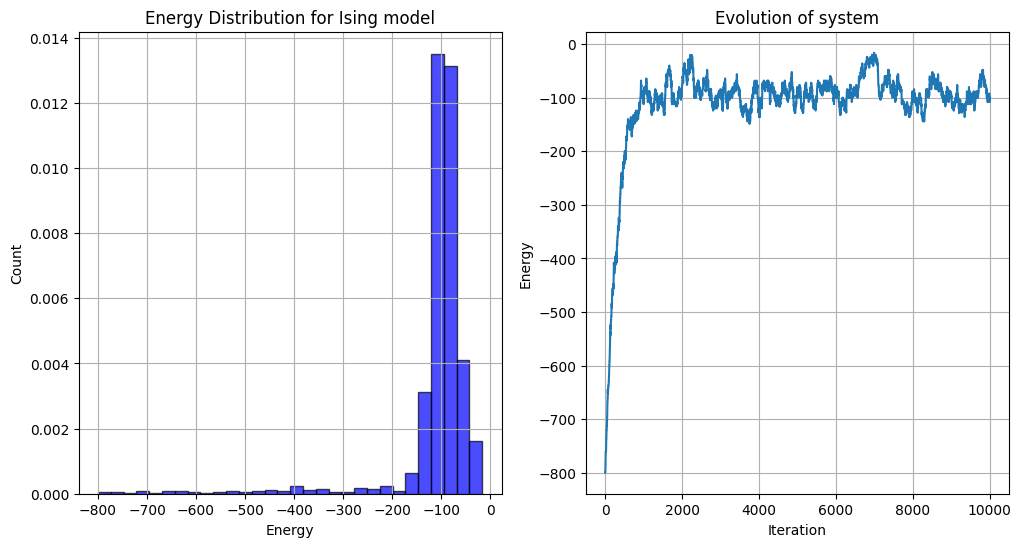

In [19]:
Energy_hist = gibbs_sampling(np.ones(shape=(20,20)), T=10, n_iterations=10000)         

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
axs[0].hist(Energy_hist, bins=30, density=True, alpha=0.7, color='b', edgecolor='black')
axs[0].set_xlabel('Energy')
axs[0].set_ylabel('Count')
axs[0].set_title('Energy Distribution for Ising model')
axs[0].grid()

axs[1].plot(Energy_hist)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Energy')
axs[1].set_title('Evolution of system')
axs[1].grid()

Now I'll plot magnetization for a few different temperatures. The code block below is testing that my gibbs_sampling_mag function works.

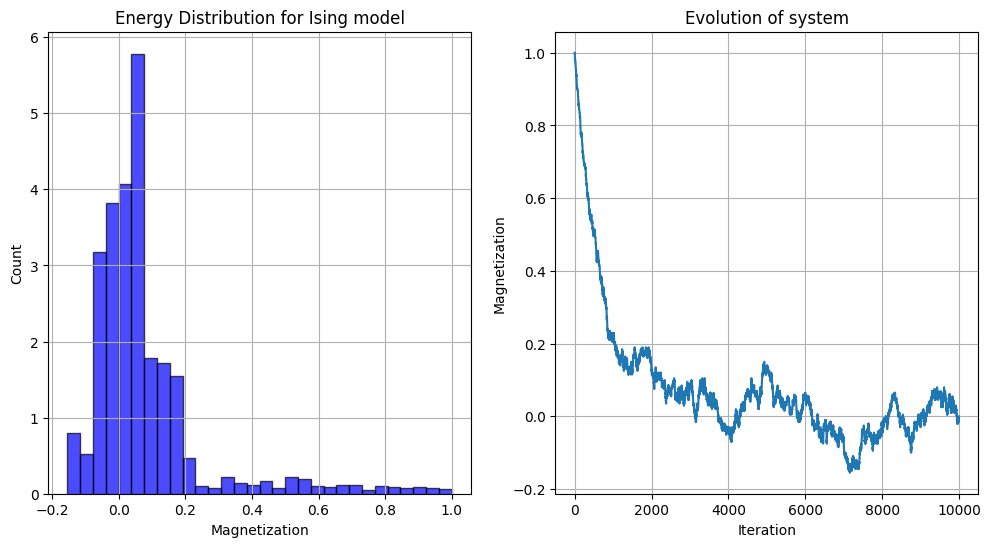

In [22]:
def gibbs_sampling_mag(lattice, J=1, B=0, T=1, n_iterations=1000):

    size = lattice.shape[0]

    M_history = []        #stores the energies of the lattices we've sampled
    
    for _ in range(n_iterations):
        i, j = np.random.randint(0, size, size=2)  # Select a random spin
        S = lattice[i, j]
        
        neighbors = lattice[(i+1) % size, j] + lattice[(i-1) % size, j] + \
                    lattice[i, (j+1) % size] + lattice[i, (j-1) % size]
        
        delta_E = 2 * J * S * neighbors + 2 * B * S
        
        p = 1 / (1 + np.exp(delta_E / T))  # Gibbs probability
        
        if np.random.rand() < p:
            lattice[i, j] *= -1  # Flip spin with probability p

        M_history.append(np.sum(lattice)/(size**2))
    
    return M_history



M_hist = gibbs_sampling_mag(np.ones(shape=(20,20)), T=10, n_iterations=10000)         

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
axs[0].hist(M_hist, bins=30, density=True, alpha=0.7, color='b', edgecolor='black')
axs[0].set_xlabel('Magnetization')
axs[0].set_ylabel('Count')
axs[0].set_title('Energy Distribution for Ising model')
axs[0].grid()

axs[1].plot(M_hist)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Magnetization')
axs[1].set_title('Evolution of system')
axs[1].grid()

Text(0.5, 1.0, 'Phase Transition')

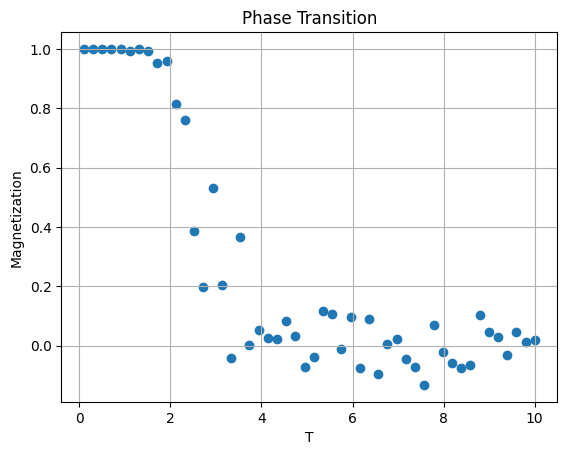

In [26]:
Tvals = np.linspace(0.1,10,50)
M_converge_vals = []

for Tval in Tvals:
    M_hist = gibbs_sampling_mag(np.ones(shape=(20,20)), T=Tval, n_iterations=10000)
    M_converge = np.mean(M_hist[-1000:-1])
    M_converge_vals.append(M_converge)

plt.scatter(Tvals, M_converge_vals)
plt.xlabel('T')
plt.ylabel('Magnetization')
plt.grid()
plt.title('Phase Transition')

Using the equation for $T_C$ in the section worksheet, I predict the phase transition should occur at $T ~ 2.3$. This is indeed what I see.

Text(0.5, 1.0, 'Phase Transitions')

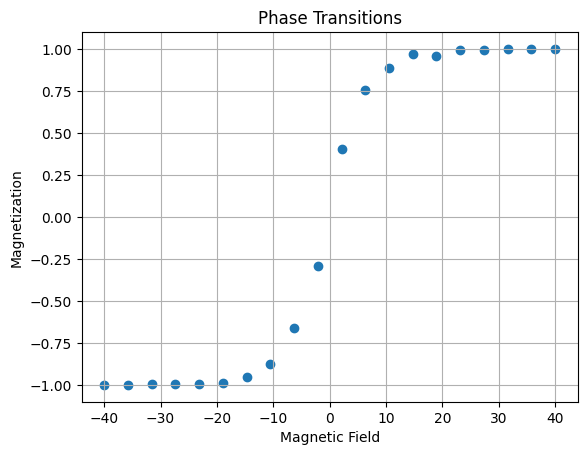

In [32]:
Bvals = np.linspace(-40, 40, 20)
M_converge_vals = []

for Bval in Bvals:
    M_hist = gibbs_sampling_mag(np.ones(shape=(20,20)), T=10, B=Bval, n_iterations=10000)
    M_converge = np.mean(M_hist[-1000:-1])
    M_converge_vals.append(M_converge)

plt.scatter(Bvals, M_converge_vals)
plt.xlabel('Magnetic Field')
plt.ylabel('Magnetization')
plt.grid()
plt.title('Phase Transitions')

Text(0.5, 1.0, 'Phase Transition')

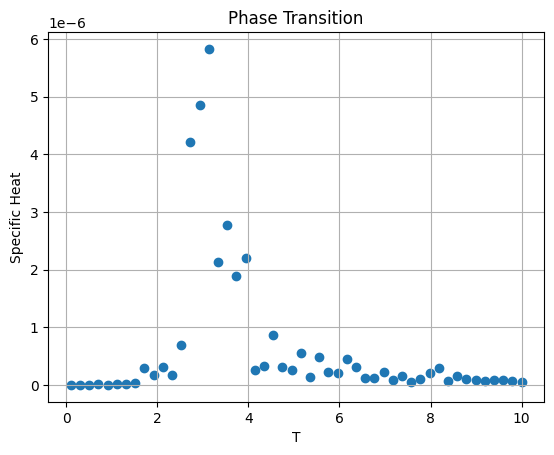

In [36]:
Tvals = np.linspace(0.1,10,50)
Cv_vals = []

for Tval in Tvals:
    E_hist = gibbs_sampling_mag(np.ones(shape=(20,20)), T=Tval, n_iterations=10000)
    E_hist = np.array(E_hist[-5000:-1])  #only keep the steady state
    C_v = 1/(Tval**2*20**2) * (np.mean(E_hist*E_hist) - (np.mean(E_hist))**2)
    Cv_vals.append(C_v)

plt.scatter(Tvals, Cv_vals)
plt.xlabel('T')
plt.ylabel('Specific Heat')
plt.grid()
plt.title('Phase Transition')